# Complex-Number Representation Link Prediction

The Complex Representation-based Link Prediction (CORLP) method predicts links between users and items by modelling relational dualities using complex numbers. By using complex numbers, the algorithm can distinguish between different types of relationships. More specifically, the similar or dissimilar links between users or items are weighted by real numbers, while the like or dislike links between users and items are weighted by complex numbers.

This is an implementation of CORLP in the context of music recommendation.

In [1]:
import numpy  as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power

import warnings
warnings.filterwarnings("ignore")


## Data Preprocessing

The data preprocessing includes filling the weights of the unrated tracks, splitting the dataframe is train/test set and creating the adjacency matrix.

In [2]:
# import the data
dataset_path = "../data/spotify_million_playlist_dataset/playlist_track_mapping_unweighted.txt"

columns = ['playlistId', 'trackId', 'weight']

df = pd.read_csv(dataset_path, 
                sep=' ',
                names=columns, 
                low_memory=False,  
                encoding="latin-1")
df.head() # check the format

,playlistId,trackId,weight
0,202269201444,718638038900,1
1,202269201444,522103160601,1
2,202269201444,808916200056,1
3,202269201444,602509086965,1
4,202269201444,635033516226,1


In [3]:
# chose a subset of the initial data between the size of 100 to 200000
df = df.iloc[:19500,:]

In [5]:
number_of_playlists = df.playlistId.unique().size
number_of_tracks  = df.trackId.unique().size

print(f"{number_of_playlists} playlists (users) containing {number_of_tracks} songs")

310 playlists (users) containing 12813 songs


In [6]:
# train - test split
df_train, df_test  = train_test_split(df, test_size=0.3, random_state=42)

# drop duplicate entries in df_train
df_train = df_train.drop_duplicates(['playlistId', 'trackId'])

# fill the weight/preference of unrated tracks with 0
df_user_item = df_train.pivot(index='playlistId', columns='trackId', values='weight').fillna(0)

# convert to NumPy array
ui = np.array(df_user_item)

In [7]:
df_user_item.head()

trackId,299507032,512219278,564370655,646511383,681992252,715610175,859323870,923225647,996662258,1029924372,...,998840276154,998855028473,998940007450,999018537321,999031286637,999065428356,999304472220,999482818991,999731325071,999990448993
playlistId,,,,,,,,,,,,,,,,,,,,,
3174342715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8229843960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8815090205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12492377828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14053753232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Complex Numbers

Elements in df_Aui that greater than 0 and less than the threshold are set to -1j to express whether a user likes item or item dislikes user, while element with values greater than the threshold express if a user dislikes an item or an item likes user.


In [12]:
threshold = 1

df_Aui = df_user_item.copy()

df_Aui[(0 < df_user_item) & (df_user_item < threshold)] = -1j
df_Aui[ df_user_item >= threshold ] = 1j

df_Aui.head()

trackId,299507032,512219278,564370655,646511383,681992252,715610175,859323870,923225647,996662258,1029924372,...,998840276154,998855028473,998940007450,999018537321,999031286637,999065428356,999304472220,999482818991,999731325071,999990448993
playlistId,,,,,,,,,,,,,,,,,,,,,
3174342715,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
8229843960,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
8815090205,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
12492377828,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
14053753232,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j


In [13]:
print(f"Number of cells with value 1j: {np.count_nonzero(df_Aui == 1j)} out of {df_Aui.size}")
print(f"Number of cells with value -1j: {np.count_nonzero(df_Aui == -1j)} out of {df_Aui.size}")

Number of cells with value 1j: 13650 out of 2998320
Number of cells with value -1j: 0 out of 2998320


# Creation of CORLP matrices

Auu matrix -> User-User similarity

Aui/iu matrix -> User-Item/Item-User preference

Aii -> Item-Item similarity

$$
    A = \begin{bmatrix} A_{UU} & A_{UI} \\ A_{UI} & A_{II} \end{bmatrix} = \begin{bmatrix} 0 & A_{UI} \\ -A_{UI}^{T} & 0 \end{bmatrix} 
$$




In [14]:
# creating user-item, item-user matrices
Aui = np.array(df_Aui)
Aiu = (Aui.T) * -1

num_user = Aui.shape[0] 
num_item = Aui.shape[1]

# creating user-user, item-item matrices
Auu = np.zeros((num_user, num_user), dtype=complex)
Aii = np.zeros((num_item, num_item), dtype=complex)

A = np.vstack([np.hstack([Auu, Aui]), 
               np.hstack([Aiu, Aii])])

Shape of Aui: (310, 9672)
Shape of Aiu: (9672, 310)
Shape of Auu: (310, 310)
Shape of Aii: (9672, 9672)
	       Shape of A (9982, 9982)

			A
-------------------------------------------------------
 [[ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [-0.+0.j -0.+0.j -0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]]


In [ ]:
def calculate_matrix_power_of(A):
    powers_of_A = []
    for power in  range(3,10,2):
        powers_of_A.append(matrix_power(A, power) )
    return powers_of_A

In [15]:
powers_of_A = calculate_matrix_power_of(A)

unrated_track_indexes = np.where(df_user_item==0)
arr = np.array(unrated_track_indexes)
arr.shape


	       Shape of A^9 (9982, 9982)

			A^9
		--------------------
[[0.      +0.j 0.      +0.j 0.      +0.j ... 0.  +25839.j 0. +414583.j
  0.+7616420.j]
 [0.      +0.j 0.      +0.j 0.      +0.j ... 0.  +13522.j 0.  +67155.j
  0.+1122908.j]
 [0.      +0.j 0.      +0.j 0.      +0.j ... 0.  +24108.j 0. +339226.j
  0.+3364818.j]
 ...
 [0.  -25839.j 0.  -13522.j 0.  -24108.j ... 0.      +0.j 0.      +0.j
  0.      +0.j]
 [0. -414583.j 0.  -67155.j 0. -339226.j ... 0.      +0.j 0.      +0.j
  0.      +0.j]
 [0.-7616420.j 0.-1122908.j 0.-3364818.j ... 0.      +0.j 0.      +0.j
  0.      +0.j]]


(2, 2984670)

In [16]:
THRES = 0.5

def calculate_accuracy(df_test, recommended_track_id):
    # filter recommended tracks with weight above THREs
    recommended_tracks_above_threshold = df_test[df_test['trackId'].isin(recommended_track_id) & (df_test['weight'] > THRES)]

    # number of correctly recommended tracks
    correct_recommendations_count = len(recommended_tracks_above_threshold)

    total_tracks_in_test_set = len(df_test)
    accuracy = correct_recommendations_count / total_tracks_in_test_set

    return accuracy

def calculate_precision(df_test, recommended_track_id):
    recommended_tracks_above_threshold = df_test[df_test['trackId'].isin(recommended_track_id) & (df_test['weight'] > THRES)]

    # number of correctly recommended tracks
    true_positives = len(recommended_tracks_above_threshold)

    # number of tracks recommended by the model
    total_recommendations = len(recommended_track_id)

    precision = true_positives / total_recommendations if total_recommendations > 0 else 0

    return precision

def calculate_recall(df_test, recommended_track_id):
    actual_tracks_above_threshold = df_test[df_test['weight'] > THRES]

    # number of correctly recommended tracks
    true_positives = len(actual_tracks_above_threshold[actual_tracks_above_threshold['trackId'].isin(recommended_track_id)])

    # total number of actual tracks
    total_actual_tracks = len(actual_tracks_above_threshold)

    recall = true_positives / total_actual_tracks if total_actual_tracks > 0 else 0

    return recall

def calculate_f1_score(precision, recall):
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1_score


In [17]:
def test_recommender_system(A, N):
  # final matrix A with score additions by CORLP
  trained_Aui = A[0: number_of_playlists,
                 number_of_playlists:A.shape[1]]
  
  # sorting to get the best scores in the beggining
  indexes = (-trained_Aui).argsort(axis=1)
  
  # masking already rated songs of users
  rec = {}
  for u in range(0, number_of_playlists):
    mask   = np.isin(indexes[u],unrated_track_indexes[u])
    rec[u] = indexes[u][mask]
  
  # top-N for each playlist (user)
  recommended_item_indexes = np.zeros((number_of_playlists, N), dtype=int)
  for u in range(0, number_of_playlists):
    row = rec[u][:N]
    recommended_item_indexes[u] = row

  # converting the indexes to the actual ids of the song
  recommended_track_id = df_user_item.columns[recommended_item_indexes.ravel()]
 
  # calculating metrics
  coverage = len(np.unique(recommended_track_id)) / number_of_tracks
  accuracy = calculate_accuracy(df_test, recommended_track_id)
  precision = calculate_precision(df_test, recommended_track_id)
  recall = calculate_recall(df_test, recommended_track_id)
  f1 = calculate_f1_score(precision, recall)
  
  return (coverage, accuracy, precision, recall, f1)

In [ ]:
#
unrated_track_indexes = {}
for A, B in zip(arr[0], arr[1]):
  if A in unrated_track_indexes:
    unrated_track_indexes[A].append(B)
    print(A, B)
  else:
    unrated_track_indexes[A] = [B]

In [18]:
test_results = {}

number_of_recommended_item = np.arange(10, 110, 10) 

power = 3
for A in tqdm(powers_of_A):
  for N in tqdm(number_of_recommended_item):
    
    result = test_recommender_system(A, N)
    
    if power in test_results:
      test_results[power].append(result)
    else:
      test_results[power] = [result]
      
  power += 2


100%|██████████| 4/4 [02:03<00:00, 30.83s/it]


In [19]:
test_results_a = test_results

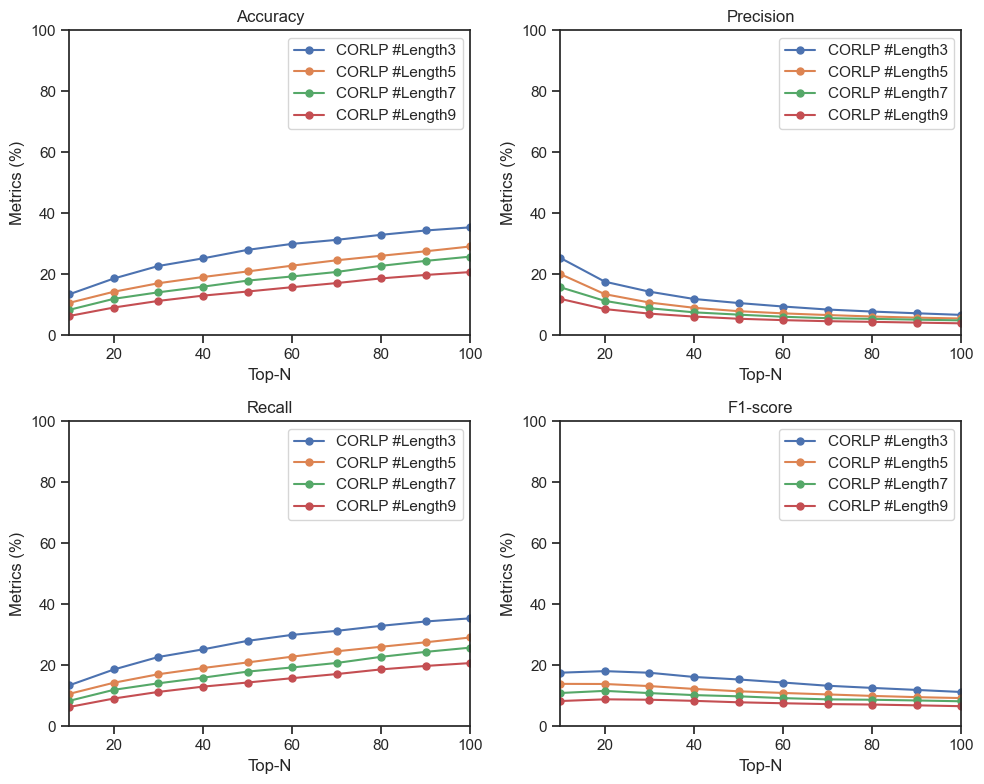

In [20]:
sns.set(style="ticks")

x = np.arange(10, 110, 10)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

metrics = {'Accuracy': 1, 'Precision': 2, 'Recall': 3, 'F1-score': 4}

for i, (label, metric_index) in enumerate(metrics.items()):
    y = []
    for key, value in test_results_a.items():
        y_per_metric = [metric[metric_index] * 100 for metric in value]
        y.append(y_per_metric)

    for j, y_values in enumerate(y):
        axs[i].plot(x, y_values, marker='o', markersize=5, label=f"CORLP #Length{list(test_results_a.keys())[j]}")

    axs[i].set_title(label)
    axs[i].set_xlabel("Top-N")
    axs[i].set_ylabel("Metrics (%)")
    axs[i].set_xlim(x.min(), x.max())
    axs[i].set_ylim(0, 100)
    axs[i].legend()

plt.tight_layout()
plt.show()

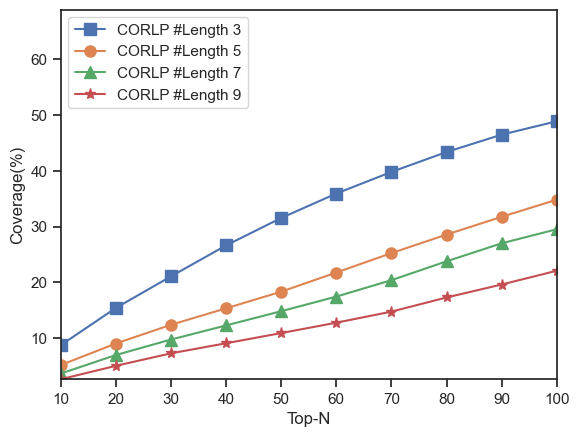

In [36]:
sns.set(style="ticks")

x = np.arange(10, 110, 10)
test_results_b_values = [coverage[0] * 100 for values in test_results_a.values() for coverage in values]

markers = ['s', 'o', '^', '*']
labels = ['CORLP #Length 3', 'CORLP #Length 5', 'CORLP #Length 7', 'CORLP #Length 9']

fig, ax = plt.subplots()
for i, (marker, label) in enumerate(zip(markers, labels)):
    ax.plot(x, test_results_b_values[i * 10: (i + 1) * 10], marker=marker, markersize=8, label=label)

plt.xlabel("Top-N")
plt.ylabel("Coverage(%)")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(min(test_results_b_values), max(test_results_b_values) + 20)

leg = ax.legend(loc='upper left')

# part B

In [37]:
from surprise import Reader, Dataset, SVD
from sklearn.metrics.pairwise import cosine_similarity

In [38]:
reader = Reader()

data = Dataset.load_from_df(df_train[['playlistId', 'trackId', 'weight']], reader)
train_set = data.build_full_trainset()

svd = SVD(n_factors=2)
trained_data = svd.fit(train_set)

pu = trained_data.pu
qi = trained_data.qi

In [39]:
cos_threshold = 0.5

# finding similarities between users
pu_similarities = cosine_similarity(pu)

pu_similarities[pu_similarities >= cos_threshold] =  1
pu_similarities[pu_similarities <  cos_threshold] = -1

Auu = pu_similarities

# finding similarities between items
qi_similarities = cosine_similarity(qi)

qi_similarities[qi_similarities >= cos_threshold] =  1
qi_similarities[qi_similarities <  cos_threshold] = -1

Aii = qi_similarities

B = np.vstack([np.hstack([Auu, Aui]), 
               np.hstack([Aiu, Aii])])

In [41]:
powers_of_B = calculate_matrix_power_of(B)


	       Shape of A^9 (9982, 9982)

			A^9
		--------------------
[[-7.06944753e+23+0.00000000e+00j -7.33181758e+23+0.00000000e+00j
  -1.29307373e+24+0.00000000e+00j ...  0.00000000e+00+4.25871760e+26j
   0.00000000e+00-3.69699050e+26j  0.00000000e+00+9.22123773e+25j]
 [-7.33181758e+23+0.00000000e+00j -1.00773925e+23+0.00000000e+00j
  -1.31788492e+24+0.00000000e+00j ...  0.00000000e+00-2.87159218e+26j
   0.00000000e+00-2.20089584e+26j  0.00000000e+00+5.64083835e+26j]
 [-1.29307373e+24+0.00000000e+00j -1.31788492e+24+0.00000000e+00j
   2.44202329e+24+0.00000000e+00j ...  0.00000000e+00-2.53162531e+25j
   0.00000000e+00+1.45625769e+27j  0.00000000e+00-1.05902930e+27j]
 ...
 [ 0.00000000e+00-4.25871760e+26j  0.00000000e+00+2.87159218e+26j
   0.00000000e+00+2.53162531e+25j ...  6.99180067e+29+0.00000000e+00j
  -3.17278622e+29+0.00000000e+00j -3.82420615e+29+0.00000000e+00j]
 [ 0.00000000e+00+3.69699050e+26j  0.00000000e+00+2.20089584e+26j
   0.00000000e+00-1.45625769e+27j ... -3.17278622e+

In [42]:
test_results = {}

number_of_recommended_item = np.arange(10, 110, 10) 

power = 3
for B in tqdm(powers_of_B):
  for N in tqdm(number_of_recommended_item):
    
    result = test_recommender_system(B, N)
    
    if power in test_results:
      test_results[power].append(result)
    else:
      test_results[power] = [result]
  
  power += 2

100%|██████████| 4/4 [02:00<00:00, 30.03s/it]


In [43]:
test_results_b = test_results

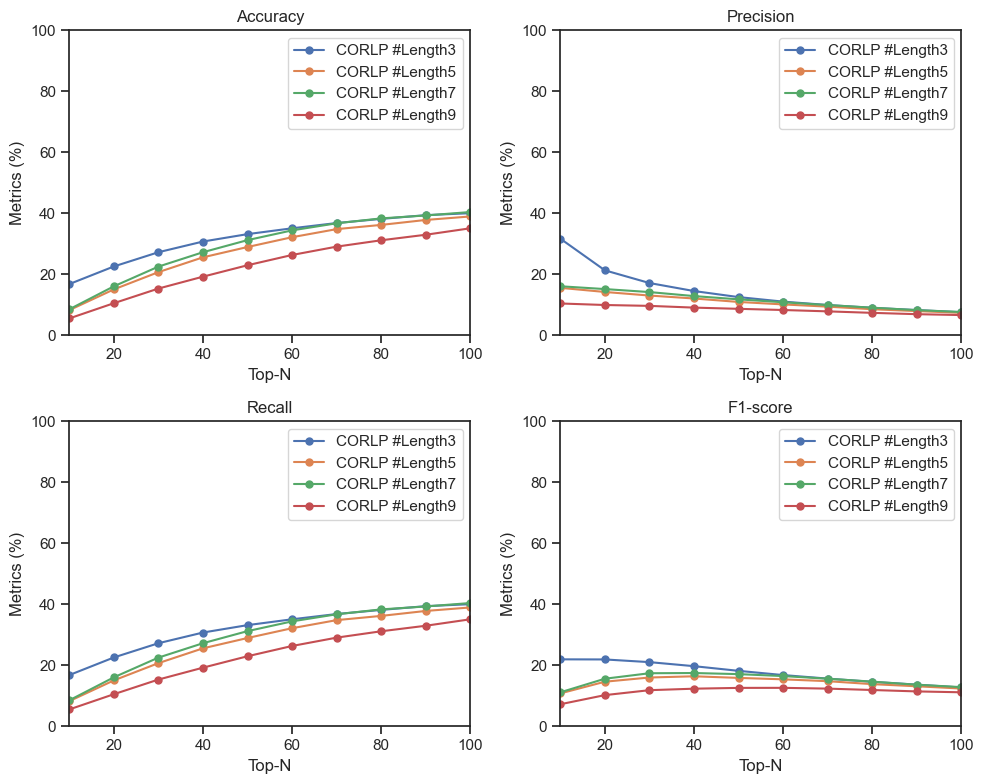

In [44]:
sns.set(style="ticks")

x = np.arange(10, 110, 10)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

metrics = {'Accuracy': 1, 'Precision': 2, 'Recall': 3, 'F1-score': 4}

for i, (label, metric_index) in enumerate(metrics.items()):
    y = []
    for key, value in test_results_b.items():
        y_per_metric = [metric[metric_index] * 100 for metric in value]
        y.append(y_per_metric)

    for j, y_values in enumerate(y):
        axs[i].plot(x, y_values, marker='o', markersize=5, label=f"CORLP #Length{list(test_results_a.keys())[j]}")

    axs[i].set_title(label)
    axs[i].set_xlabel("Top-N")
    axs[i].set_ylabel("Metrics (%)")
    axs[i].set_xlim(x.min(), x.max())
    axs[i].set_ylim(0, 100)
    axs[i].legend()

plt.tight_layout()
plt.show()

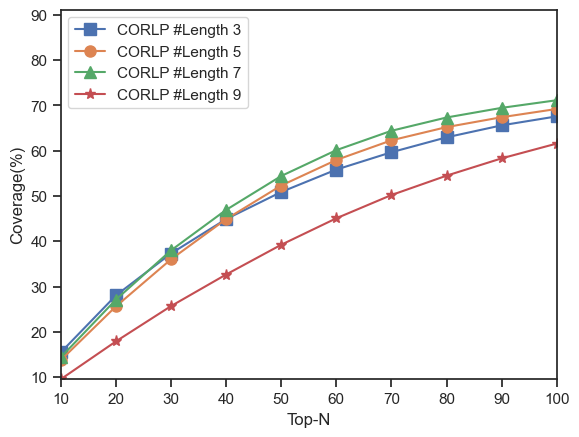

In [45]:
sns.set(style="ticks")

x = np.arange(10, 110, 10)
test_results_b_values = [coverage[0] * 100 for values in test_results_b.values() for coverage in values]

markers = ['s', 'o', '^', '*']
labels = ['CORLP #Length 3', 'CORLP #Length 5', 'CORLP #Length 7', 'CORLP #Length 9']

fig, ax = plt.subplots()
for i, (marker, label) in enumerate(zip(markers, labels)):
    ax.plot(x, test_results_b_values[i * 10: (i + 1) * 10], marker=marker, markersize=8, label=label)

plt.xlabel("Top-N")
plt.ylabel("Coverage(%)")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(min(test_results_b_values), max(test_results_b_values) + 20)

leg = ax.legend(loc='upper left')